# Evaluating Forecasts 
<hr style="border:2px solid black">

## 1. Model Building Revisited

### 1.1 Load Packages

In [ ]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# machine learning stack
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder
)
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV
)
from sklearn.model_selection import train_test_split

# miscellaneous
import time
import warnings
warnings.filterwarnings("ignore")

### 1.2 Load Train Data

In [ ]:
df = pd.read_csv(
    '../data/milk_train.csv', index_col=0, parse_dates=True
)
df.head()

### 1.3 Baseline Model

**timestep column**

In [ ]:
df['timestep'] = list(range(df.shape[0]))

In [ ]:
df.tail()

**month column**

In [ ]:
df['month'] = df.index.month

In [ ]:
df.tail()

**dataframe copy**

In [ ]:
train = df.copy()

**features and target**

In [ ]:
X_train_baseline = train[['timestep','month']]
y_train = train['production']

**column transformation**

In [ ]:
col_transformer = ColumnTransformer([
    ('poly', PolynomialFeatures(degree=2), ['timestep']),
    ('ohe', OneHotEncoder(drop='first'), ['month'])
])

**baseline model pipeline**

In [ ]:
baseline_model = make_pipeline(
    col_transformer,
    LinearRegression()
)

**build baseline model**

In [ ]:
baseline_model.fit(X_train_baseline, y_train)

**predict train data**

In [ ]:
train['trend_seasonal'] = baseline_model.predict(X_train_baseline)

**check results**

In [ ]:
train[['production','trend_seasonal']].tail()

### 1.4 Model Remainder

**extract remainder**

In [ ]:
train['remainder'] = train['production'] - train['trend_seasonal']

**lag columns**

In [ ]:
# create lag column in dataframe
train['lag_1'] = train['remainder'].shift(1)

In [ ]:
train[train.columns[-2:]].head()

**drop missing values**

In [ ]:
train.dropna(inplace=True)

**features and target**

In [ ]:
X_remainder = train[train.columns[-1:]]
y_remainder = train['remainder']

**train model**

In [ ]:
ar_model = LinearRegression()
ar_model.fit(X_remainder,y_remainder)

**predict remainder**

In [ ]:
train['remainder_pred'] = ar_model.predict(X_remainder)

### 1.5 Complete Model

**total prediction**

In [ ]:
train['total_pred'] = \
train['trend_seasonal'] + train['remainder_pred']

**check results**

In [ ]:
train[['production','trend_seasonal','total_pred']].tail()

**plots**

In [ ]:
mpl.rc('figure',figsize=(12,3),dpi=100)
train[['production','trend_seasonal','total_pred']].plot(legend=True)
sns.despine()

### 1.6 Model Evaluation

**baseline model**

In [ ]:
r2_ts = round(baseline_model.score(X_train_baseline,y_train),6)
print(f"r2_score: {r2_ts}")

**complete model**

In [ ]:
r2_tot = round(r2_score(y_train[1:],train['total_pred']),6)
print(f"r2_score: {r2_tot}")

<hr style="border:2px solid black">

## 2. Forecasts

### 2.1 Load Test Data

In [ ]:
test = pd.read_csv(
    '../data/milk_test.csv',index_col=0,parse_dates=True
)
test.head()

### 2.2 Baseline Forecasts

**timestep column**

In [ ]:
test['timestep'] = list(
    range(df.shape[0], df.shape[0]+test.shape[0])
)

In [ ]:
test['timestep']

**month column**

In [ ]:
test['month'] = test.index.month

**features and target**

In [ ]:
X_test_baseline = test[['timestep','month']]
y_test = test['production']

**baseline forecasts**

In [ ]:
test['baseline_pred'] = baseline_model.predict(X_test_baseline)

**check forecasts**

In [ ]:
test[['production','baseline_pred']].head()

In [ ]:
test[['production','baseline_pred']].tail()

### 2.3 Complete Forecasts

**remainder forecasts**

In [ ]:
def forecast_remainder(*lags):
    """
    spits out forecasted remainder for test data,
    given initial lagged variables
    """
    predicted_remainders = []
    lag_values = list(lags)
    
    for i in range(test.shape[0]):
        
        # row of lagged features
        X = [lag_values]
        
        # predict remainder
        remainder = ar_model.predict(X)[0]
        
        # append remainded
        predicted_remainders.append(remainder)
        
        # lag values for next step
        lag_values = [remainder] + lag_values[:-1]
        
    return predicted_remainders

**lags for first month**

In [ ]:
lag1 = train.iloc[-1]['remainder'] 

- ***comment: remainder forecast is meaningful only for short term!***

**total forecasts**

In [ ]:
test['total_pred'] = \
test['baseline_pred'] + forecast_remainder(lag1)

**check forecasts**

In [ ]:
test[['production','baseline_pred','total_pred']].head()

**plots**

In [ ]:
mpl.rc('figure',figsize=(12,3),dpi=100)
test[['production','baseline_pred','total_pred']].plot(legend=True)
sns.despine()

### 2.4 Model Performance

**baseline model**

In [ ]:
r2_ts = round(baseline_model.score(X_test_baseline,y_test),6)
print(f"r2_score: {r2_ts}")

**complete model**

In [ ]:
r2_tot = round(r2_score(y_test,test['total_pred']),6)
print(f"r2_score: {r2_tot}")

<hr style="border:2px solid black">

## 3. Baseline Model II

- hyperparameter tuning with cross-validation

### 3.1 Time-Series Cross-Validation

- ordinary cross validation cannot be used because of time ordering
- cross-validation on a rolling basis (sliding window)

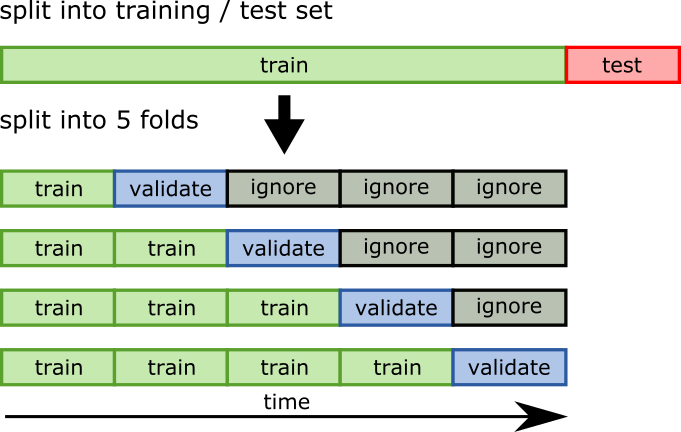

**features and target**

In [ ]:
Xb = df[['timestep','month']]
yb = df['production']

**column transformation**

In [ ]:
transformer = ColumnTransformer([
    ('poly', PolynomialFeatures(), ['timestep']),
    ('ohe', OneHotEncoder(drop='first'), ['month'])]
)

**grid estimator**

In [ ]:
estimator = Pipeline([
        ('transformer', transformer),
        ('lr', LinearRegression())]
)

**parameter grid**

In [ ]:
param_grid = {'transformer__poly__degree': [2,3,4]}

**3-fold cross-validator**

In [ ]:
cv = TimeSeriesSplit(n_splits=3)

**instantiate GridSearchCV**

In [ ]:
gscv = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring='r2',
    cv=cv, 
    n_jobs=-1
)

**grid-search cross-validation**

In [ ]:
# initial time
ti = time.time()

# grid-search cross-validation
gscv.fit(Xb,yb)

# final time 
tf = time.time()

# time taken
print(f"time taken: {round(tf-ti,2)} sec")

**cross-validation results**

In [ ]:
gscv.cv_results_

In [ ]:
column_list = ['param_transformer__poly__degree',
               'mean_test_score',
               'std_test_score',
               'rank_test_score'
              ]
result_df = pd.DataFrame(gscv.cv_results_)[column_list]

result_df.rename(
    columns=lambda name: name.split('__')[-1],inplace=True
)
result_df

**best hyperparameters**

In [ ]:
gscv.best_params_

### 3.2 Build Model

**instantiate best estimator**

In [ ]:
baseline_model_cv = gscv.best_estimator_

**build model**

In [ ]:
baseline_model_cv.fit(Xb,yb)

### 3.3 Forecasts

**improved baseline forecasts**

In [ ]:
test['baseline_pred_cv'] = baseline_model_cv.predict(X_test_baseline)

**check forecasts**

In [ ]:
test[['production','baseline_pred','baseline_pred_cv']].head()

**model performance**

In [ ]:
r2_bimp = round(baseline_model_cv.score(X_test_baseline,y_test),6)
print(f"r2_score: {r2_bimp}")

<hr style="border:2px solid black">

## 4. Remainder Model II

- use a smart alternative evaluation metric instead of cross-validation 
- metric should take care of both over- and underfitting

### 4.1 `Akaike Information Criterion (AIC)`

>$$
\text{AIC} = 2k - 2\log\hat{L}
$$
>- $k =$ number of estimated parameters in the model; penalizes overfitting
>- $\hat{L} = $ maximum value of the likelihood function for the model; penalizes underfitting
>- the lower the AIC, the better the model

### 4.2 Model Selection

**extract remainder**

In [ ]:
df['remainder'] = df['production'] - baseline_model_cv.predict(Xb)

`pip install pmdarima`
- ARIMA estimators for Python

In [ ]:
import pmdarima as pm

In [ ]:
arima_model = pm.auto_arima(
    df['remainder'], 
    start_p=0,
    max_p=5,
    seasonality = False,
    stationarity = True,
    trace = True,
    n_jobs=-1
)

In [ ]:
df['arima_predictions'] = arima_model.predict_in_sample()

# Plot original remainder and prediction
mpl.rc('figure',figsize=(12,3),dpi=100)

df[['remainder','arima_predictions']].plot(legend=True)
sns.despine()

### 4.3 Total Improved Forecasts

**improved forecasts**

In [ ]:
test['arima_pred'] = \
arima_model.predict(test.shape[0], return_conf_int=True)[0]

test['total_pred_new'] = test['baseline_pred_cv'] + test['arima_pred']

**check forecasts**

In [ ]:
test[['production','total_pred','total_pred_new']].head()

**plots**

In [ ]:
mpl.rc('figure',figsize=(12,3),dpi=100)
test[['production','total_pred','total_pred_new']].plot(figsize=(12,4),legend=True)
sns.despine()

**model performance**

In [ ]:
r2_timp = round(r2_score(test['production'],test['total_pred_new']),6)
print(f"r2_score: {r2_timp}")

<hr style="border:2px solid black">

## References

- Forecasting: Principles and Practice, R. J. Hyndman & G. Athanasopoulos,
[OTexts Free Online Book](https://otexts.com/fpp3/)
- [Cross Validation in Time Series](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4)